In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import random
import sqlite3 as sql
import requests
import time
import nltk.corpus as nl
import statsmodels.api as sm
#import nlkt #uncheck if download of nltk is needed
#nltk.download('words')
#nltk.download('stopwords')

/Users/David/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
# You will start by downloading the data from the Kaggle link provided and import it into pandas (en.openfoodfacts.org.products.tsv). 
# You will then need to clean this data using the tools and methods covered in this course. 
# There is not just one correct way to do this. Several solutions will be accepted as long as you demonstrate that you have thoroughly cleaned the data. 
# This includes, of course, dealing with missing values, normalizing entries and text data, dealing with duplicates or incorrect values or getting certain data in more useful formats.

# Download and read the data from tsv
food = pd.read_csv("~/Desktop/EPFL Applied ML/en.openfoodfacts.org.products.tsv", sep='\t', low_memory=False, parse_dates=[3,4,5,6]) #change path if needed
# Import the data as a pandas DataFrame
food = pd.DataFrame(food) # a dataframe of food.shape = 356027 x 163 is obtained

In [6]:
# Remove NaN only if full column or row has NaN values
food = food.dropna(axis=[0,1],how='all') # food.shape = 356027 x 147

In [7]:
# Identify columns that could be eliminated based on data structure: print all possible columns and their NaN values
with pd.option_context('display.max_rows', None):
    print(food.isnull().sum())

code                                              26
url                                               26
creator                                            3
created_t                                          0
created_datetime                                   0
last_modified_t                                    0
last_modified_datetime                             0
product_name                                   17512
generic_name                                  298313
quantity                                      236742
packaging                                     266068
packaging_tags                                266068
brands                                         29050
brands_tags                                    29070
categories                                    252728
categories_tags                               252752
categories_en                                 252726
origins                                       330977
origins_tags                                  

In [8]:
# code and url have 26 NaN, and a quick peak at the data using food[food['code'].isnull()] reveals that the data acquisition has been ill-performed for these products. Even if we could trace back what they are by using other columns, reclassifying them would be 1) incorrect because we would need to infer data we don't know and we are not familiar with, and 2) would not add much more information to the dataframe (26 rows VS >300000). We therefore drop them.
food=food[food['code'].notnull()]

# This operation resulted in 5 columns having only NaN values (this can be checked by running food.isnull().sum()[food.isnull().sum()==len(food)]), so they can be dropped as well.
food = food.dropna(axis=[0,1],how='all').reset_index(drop=True) # food.shape = 356001 x 142. The index is reset because of the steps that will follow.

In [9]:
# A quick look at some of the entries shows that more cleaning is needed:
print(food.loc[355951,'ingredients_text'])
print(food.loc[355952,'ingredients_text'])

# These two examples show that the actual url does not exist, and it looks like people have been having fun at uploading nonsense on the world food facts database. Furthermore, the urls for these two entries are broken.

Du sperme de la viande du viagra
LES SCHTROUMPFS t, LES SCHTROUMPFS NOIRS 2. LE SCHTROUMPFISSIME 3 SCHTROUMPFETTE L'ŒUF ET LES SCHTROUMPFS 5, LES SCHTROUMPFS ET LE CRACOUCASS 6. LE COSMOSCHTROUMPF 7, L'APPRENTI SCHTROUMPF 8. HISTOIRES DE SCHTROUMPFS 9, SCHTROUMPF VERT ET VERT SCHTROUMPF 10. LA SOUPE AUX SCHTROUMPFS 1 1, LES SCHTROUMPFS OLYMPIQUES 12, LE BÉBÉ SCHTROUMPF 13. LES P'TITS SCHTROUMPFS Id. L'AÉROSCHTROUMPF 15, L'ÉTRANGE RÉVEIL DU SCHTROUMPF PARESSEUX 16. LE SCHTROUMPF FINANCIER 17. LE SCHTROUMPFEUR DE BIJOUX 18. DOCTEUR SCHTROUMPF 19. LE SCHTROUMPF SAUVAGE 20. LA MENACE SCHTROUMPF 21. ON NE SCHTROUMPFE PAS LE PROGRÈS 22. LE SCHTROUMPF REPORTER 23. LES SCHTROUMPFS JOUEURS u. SAIADE DE SCHTROUMPFS 25. UN ENFANT CHEZ LES SCHTROUMPFS 26. LES SCHTROUMPFS ET LE LIVRE QUI DIT TOUT SCHTROUMPF LES BAINS B. GRANDE SCHTROUMPFETrE LES SCHTROUMPFS ET L'ARBRE D'OR O. LES SCHTROUMPFS DE L'ORDRE l, LES SCHTROUMPFS À PILULIT 2. LES SCHTROUMPFS ET L'AMOUR SORCIER 3. SCHTROUMPF LE HÉROS , LES S

In [10]:
# For further cleaning, check if the url of the product actually exists in the world food facts database, so that entries with non-existent webpages can be removed. For peace of mind, it will also be checked that all the entries belong to the world food facts database. The web_check vector will be saved as csv and provided with the jupyter notebook to avoid having to repeat this operation as it is extremely time consuming (~5 days)

food['url'].str.startswith("http://world-en.openfoodfacts.org/product").unique() # only one value returned (True), so all the urls point back to the same website

#web_check=[] ## uncheck if first time running the web search only
#pd.DataFrame(web_check).to_csv("C:/Users/David Framil/web_check.csv") ## uncheck if first time running the web search only

array([ True])

In [11]:
# This loop will request the status code of the web address to see if it exists or if it gives back an error. The loop is designed to keep on working until the length of the web_check vector is the same as the length of the original food dataframe. 
# Furthermore, in case the connection is lost, it saves the data in appended chunks of 500 to a csv file and recognizes the last entry, from which it builds upon. For speed, it might be wiser to choose a higher chunksize. 
# Uncheck all the loop if you want to give a try to building the web_check csv and o not forget to write the path to/from where this csv file will be read.

#while len(web_check) <= len(food):
    #if pd.read_csv("~/Desktop/EPFL Applied ML/web_check.csv").empty:
        #for weburl in food.loc[:,'url']:
            #request = requests.get(weburl)
            #if request.status_code == 200:
                #outcome = True
            #else:
                #outcome = False
            #web_check.append(outcome)
            #pd.DataFrame(web_check).to_csv("~/Desktop/EPFL Applied ML/web_check.csv", index=False, chunksize=500)
    #else:
        #web_check=pd.read_csv("~/Desktop/EPFL Applied ML/web_check.csv").iloc[:,0].tolist()
        #start=pd.read_csv("~/Desktop/EPFL Applied ML/web_check.csv").index[-1]
        #for weburl in food.loc[(start+1):len(food),'url']:
            #request = requests.get(weburl)
            #if request.status_code == 200:
                #outcome = True
            #else:
                #outcome = False
            #web_check.append(outcome)
            #pd.DataFrame(web_check).to_csv("~/Desktop/EPFL Applied ML/web_check.csv", index=False, chunksize=500)
    #if len(web_check) == len(food):
        #break

In [12]:
web_df=pd.read_csv("~/Desktop/EPFL Applied ML/web_check.csv")
web_df=web_df[web_df[['0']]==False][['0']].dropna(how='all').index.tolist()
food=food.loc[~food.index.isin(web_df)] # food.shape = 354975 x 142. Only 1026 rows have been dropped overall, which is really a meagre number provided the time spent on the search. Might not actually be a useful approach to the cleaning procedure. 

In [13]:
#check for duplicates
len(food[food.duplicated(keep=False)]) #outcome is zero so there are no duplicates

0

In [14]:
# The cleaning results are quite poor for the moment being, so we will force a more thorough cleaning in order to frame the subsequent analysis. Let's first have a look at the remaining columns and the amount of information (in terms of NA values) contained in them.

with pd.option_context('display.max_rows', None):
    print(food.isnull().sum())
    
# We can see that a maximum amount of information to identify nutritional trends is contained in the following columns that have a lower number of NAs, for example: energy_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, proteins_100g, salt_100g, sodium_100g... to keep the information significant, we will drop all the columns in which the number of NAs is above the median number of NAs. Same for the rows.
food=food.dropna(axis=1, thresh=food.notnull().sum(axis=0).median()) # food.shape = 356001 x 71
food=food.dropna(axis=0, thresh=food.notnull().sum(axis=1).median()) # food.shape = 211691 x 71

code                                               0
url                                                0
creator                                            3
created_t                                          0
created_datetime                                   0
last_modified_t                                    0
last_modified_datetime                             0
product_name                                   17156
generic_name                                  297386
quantity                                      236087
packaging                                     265221
packaging_tags                                265221
brands                                         28538
brands_tags                                    28558
categories                                    251934
categories_tags                               251934
categories_en                                 251934
origins                                       329987
origins_tags                                  

In [15]:
# The dataframe is sufficiently trimmed, but a further look makes it evident that some columns still add no information whatsoever that could be useful in the analysis, such as: 
to_drop=['url', 'creator', 'packaging_tags', 'brands_tags', 'origins', 'categories', 'categories_en', 'categories_tags','manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'countries', 'countries_tags', 'traces_tags', 'traces_en', 'additives_n', 'additives', 'additives_en', 'states', 'states_tags', 'states_en', 'main_category', 'image_url', 'image_small_url']
food.drop(columns=to_drop, inplace=True) # food.shape = 211691 x 43 # works with pandas 0.21 and further versions.
food.reset_index(drop=True, inplace=True) # reset the index for further cleaning purposes

In [16]:
# To simplify the analysis, we will first homogeneize the countries column. A look at its unique values (food['countries_en'].unique()) shows that there are groups of countries that appear listed together within a single entry. Furthermore, the listing within the entry is not consistent (some appear in other languages (and characters) or tagged with the language itself (eg, fr:)). 
# The first step will be to split up the columns by countries and create new entries for them.

food_indexed=food.set_index(food.code) # choose 'code' as index
in_between=pd.DataFrame(food_indexed.countries_en.str.split(pat=",", expand=True), index=food_indexed.index).stack().reset_index()[['code', 0]] # split based on ',' and expand the values to a dataframe. Further stack to obtain different levels based on 'code' index and re-index the resulting dataframe. Only columns with code and country are selected.
in_between.columns=['code', 'countries_en'] # rename the columns prior to merge
food_countries=pd.merge(in_between, food.drop(columns='countries_en'), on='code', how='inner') # inner merge the two dataframes based on 'code' column ('countries' column has been dropped from the food dataframe to avoid NaNs). food_countries.shape = 217638 x 43 (# rows icreased, as expected). len(food_countries['countries_en'].unique()) shows that there are 163 different country strings

In [17]:
# We can see that after the operation, there are still some country names not in the final format (food_countries['countries_en'].unique()), either because they are not in English or because they use other scripts different from latin. This step looks into replacing all these cases.
# Create a vector with all the cases that contain ':' and all the cases that do not use only alphabetic characters, and build a dictionary with the actual country names:
to_replace=np.concatenate([food_countries[food_countries.countries_en.str.contains(':')]['countries_en'].unique(), food_countries[food_countries.countries_en.str.contains('[a-z]')==False]['countries_en'].unique()])
replacement=np.array(['Canada', 'England', 'United Kingdom', 'Germany', 'Scotland', 'France', 'Spain', 'France', 'Germany', 'Mauritius', 'United Kingdom', 'France', 'France', 'France', 'France', 'Greece', 'Spain', 'Switzerland', 'Netherlands', 'Ireland', 'Belgium', 'Belgium', 'Germany', 'France', 'Switzerland', 'Danmark', 'Hong Kong', 'China', 'Japan', 'Oman', 'United Kingdom', 'Iraq'])

food_countries['countries_en'].replace(to_replace=to_replace, value=replacement, inplace=True) # food_countries.shape = 217638 x 43 (didn't change after the operation)

In [18]:
# A look at food_countries['countries_en'].unique() shows that almost all cases have been corrected (no scripts other than latin, etc...). However, the following cases still need to be handled manually (same procedure as before):
fine_to_rep=['Belgie', 'Nederland', 'Saint Pierre and Miquelon', 'Réunion', 'French Guiana', 'Aruba', 'Virgin Islands of the United States', 'Angleterre', 'Guadeloupe', 'Martinique', 'Mayotte', 'Sint Maarten', 'Allemagne', 'Republique-de-chine', 'Other-日本', 'Quebec', 'Szczecin', 'Other-turquie', 'Cook Islands', 'French Polynesia']
fine_rep=['Belgium', 'Netherlands', 'France', 'France', 'France', 'Netherlands', 'United States', 'England', 'France', 'France', 'France', 'Netherlands', 'Germany', 'China', 'Japan', 'Canada', 'Poland', 'Turkey', 'New Zealand', 'France']

food_countries['countries_en'].replace(to_replace=fine_to_rep, value=fine_rep, inplace=True) # food_countries.shape = 217638 x 43 (didn't change after the operation). len(food_countries['countries_en'].unique()) shows that the number of countries was reduced to 113.

In [19]:
# Now that the list of countries is cleaned, we will do the same for the food groups, based on the following 3 columns: 'pnns_groups_1', 'pnns_groups_2'
# For pnns1 there are actually only few replacements to do, so they can easily be done manually:
food_countries['pnns_groups_1']=food_countries['pnns_groups_1'].str.replace('-',' ')
food_countries['pnns_groups_1']=food_countries['pnns_groups_1'].str.capitalize()
food_countries['pnns_groups_1'].replace('Fish meat eggs', 'Fish, meat, eggs', inplace=True)

# For pnns2 the situation is similar (only need capitalization to reduce the number of levels):
food_countries['pnns_groups_2']=food_countries['pnns_groups_2'].str.capitalize()

# With all the prior operations we will have the same product for different countries, which is something that can actually happen. However, we still need to ensure that the prior cleaning has not produced any duplicates, and therefore drop any of them:
food_countries.drop_duplicates(keep='first', inplace=True)

In [21]:
# As a first question for analysis, we will look into the micronutrient (aka vitamins, potassium, iron, calcium) distribution.
# 1) What is the micronutrient ratio (specific micronutrient/total micronutrient content) across all foods for different countries? 
food_micro=food_countries[['product_name', 'countries_en', 'pnns_groups_1', 'pnns_groups_2', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'potassium_100g', 'calcium_100g', 'iron_100g']]
food_micro=food_micro.dropna(axis=0, how='any', subset=np.array(['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'potassium_100g', 'calcium_100g', 'iron_100g'])).reset_index()

food_ratio=food_micro.drop(columns=['product_name', 'pnns_groups_1', 'pnns_groups_2', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']) # drop columns we are not interested in
food_ratio=food_ratio.groupby(['countries_en'], axis=0).sum().drop(columns=['index']) # group by countries and sum for each of the different the micronutrients
micronutrients=['vitamin-a_100g', 'vitamin-c_100g', 'potassium_100g', 'calcium_100g', 'iron_100g'] # create a list with the original column names
micronutrients_perc=(((pd.Series(micronutrients).str.replace('_100g', ' (%)')).str.capitalize()).str.replace('-a', ' A')).str.replace('-c', ' C') # create a list with the future column names in % and with capitalization

for i in np.arange(0,len(micronutrients)):
    food_ratio[micronutrients_perc[i]]=100*food_ratio[micronutrients[i]]/food_ratio[micronutrients].sum(axis=1) # calculates the percentage composition (micronutrient_100g / sum for all micronutrient content) and adds it to a new column. by dividing 

food_ratio

,vitamin-a_100g,vitamin-c_100g,potassium_100g,calcium_100g,iron_100g,Vitamin A (%),Vitamin C (%),Potassium (%),Calcium (%),Iron (%)
countries_en,,,,,,,,,,
Argentina,0.065000,0.006000,0.09000,0.12000,0.000840,23.062731,2.128867,31.933012,42.577349,0.298041
Australia,0.000000,0.000000,1.59400,0.26800,0.004640,0.000000,0.000000,85.394077,14.357348,0.248575
Belgium,0.000181,0.008300,0.44200,0.11700,0.020300,0.030794,1.412091,75.198075,19.905373,3.453667
Canada,0.000464,0.044429,2.79510,0.83980,0.039245,0.012468,1.194637,75.156538,22.581110,1.055246
France,0.022981,2.835090,58.06910,21.05890,0.505950,0.027859,3.436805,70.393596,25.528408,0.613332
Germany,0.001309,0.182000,2.94300,1.47500,0.023700,0.028303,3.935127,63.632309,31.891830,0.512431
Malaysia,0.000000,0.000000,0.10000,0.01600,0.000290,0.000000,0.000000,85.991917,13.758707,0.249377
Netherlands,0.000000,0.000000,0.41800,0.03600,0.004910,0.000000,0.000000,91.085398,7.844675,1.069927
New Caledonia,0.000093,0.008700,0.08970,0.05890,0.000800,0.058599,5.499622,56.702996,37.233071,0.505712


Text(0.5,1,'Micronutrient distribution across all foods for different countries')

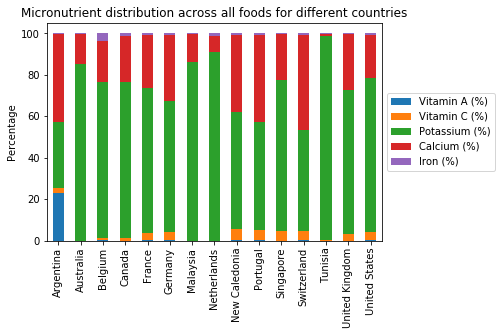

In [22]:
food_ratio[micronutrients_perc].plot.bar(stacked=True)
plt.xlabel('')
plt.ylabel('Percentage')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Micronutrient distribution across all foods for different countries')
# The higher amount of micronutrients across all foods is generally potassium followed by calcium. 
# There is a large amount of vitamin A in Argentina as well, and such a result call for some care. Indeed, a look at the original dataframe (food_micro[food_micro['countries_en']=='Argentina']) show that there is only one entry for this country. 
# As a comment, this meaningfulness problem could be adressed for all the countries, as some of them have a huge amount of information (for example, the US) while others have only few entries.

In [61]:
# 2) As a second question for analysis, we will look into the mean energy distribution for types of food per country.
food_energy=food_countries[['countries_en', 'pnns_groups_1', 'pnns_groups_2', 'energy_100g']] # select columns of interest
food_energy=food_energy.dropna(axis=0, how='any').reset_index(drop=True) # get rid of NAs

food_energy=food_energy.groupby(['countries_en', 'pnns_groups_1']).mean().unstack(level=1).dropna(axis=0, how='any') # group by pairs of countries/pnns_groups and calculate the mean of the energy content. Unstack to get the food types as columns, and keep only the countries for which data is available for all the types of foods.
food_energy.columns=food_energy.columns.droplevel() # drop the higher column level

food_energy.index.name='Country'
food_energy.columns.name='Food group'

food_energy

Food group,Beverages,Cereals and potatoes,Composite foods,Fat and sauces,"Fish, meat, eggs",Fruits and vegetables,Milk and dairy products,Salty snacks,Sugary snacks,Unknown
Country,,,,,,,,,,
Australia,216.773214,1175.186047,626.708889,1317.193548,691.960000,330.750000,805.306122,2041.000000,1819.626866,929.238760
Austria,146.905882,1374.058824,30.000000,1453.916667,1184.000000,857.666667,835.437500,2371.750000,1641.333333,1121.742857
Belgium,200.557957,1535.776243,648.846154,1712.006000,822.913514,533.751220,742.507647,2113.590909,1963.242236,1137.534595
Canada,137.400000,1372.035714,845.166667,1464.307692,675.909091,537.571429,616.608696,2424.500000,1887.200000,1246.700000
France,285.384078,1368.666680,699.880154,1807.442521,873.669223,415.469473,829.396548,2111.198026,1785.858293,1120.921203
Germany,202.565808,1359.482993,713.172131,1779.158364,927.758457,529.293727,807.844378,2295.131941,2016.812049,1156.698365
Italy,180.071875,1433.744615,1013.500000,1240.000000,852.750000,227.000000,685.232143,1861.266667,1785.976087,1205.476364
Luxembourg,189.000000,1870.666667,745.000000,2837.750000,1162.000000,161.500000,919.090909,2315.000000,1953.000000,1094.133333
Netherlands,347.612903,1755.909091,489.545455,1429.227273,861.250000,421.000000,630.531250,2282.133333,1833.759259,1250.160976


[Text(0,0.5,'Energy content'),
 Text(0,0.5,'Energy content'),
 Text(0,0.5,'Energy content'),
 Text(0,0.5,'Energy content'),
 Text(0,0.5,'Energy content'),
 Text(0,0.5,'Energy content'),
 Text(0,0.5,'Energy content'),
 Text(0,0.5,'Energy content'),
 Text(0,0.5,'Energy content'),
 Text(0,0.5,'Energy content')]

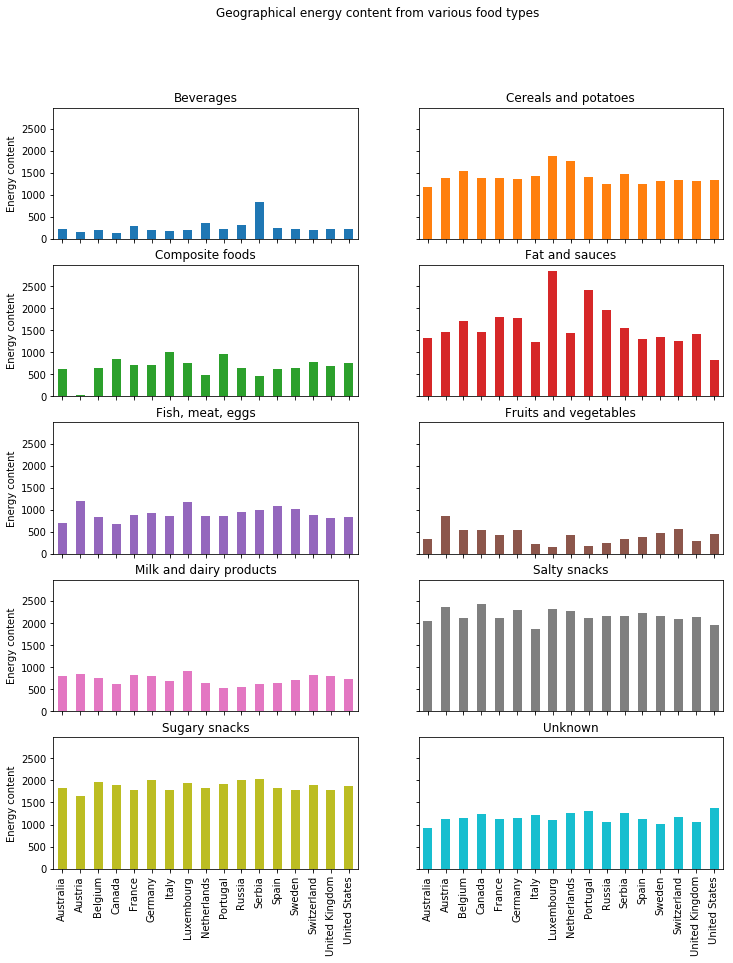

In [24]:
# The plotting will include several subplots with a shared y axis and no legend. The size will be adjusted for better visualization in the jupyter notebook
food_energy.plot.bar(subplots=True, layout=(5,2), legend=False, sharey=True, figsize=(12,14), title='Geographical energy content from various food types')

[ax.set_xlabel('') for ax in plt.gcf().axes] # Sets all the xlabel for the different axes defined to ''
[ax.set_ylabel('Energy content') for ax in plt.gcf().axes] # Sets all the ylabel for the different axes defined to 'Energy content'
# plt.gcf().axes[4].set_ylabel('Energy content') # calling in case we might need to change only one of the subplots axes labels

# It can be seen that the highest energy content usually comes from salty snacks, followed by sugary snacks, fats and sauces, and cereals and potatoes. Another way to double check this would be to call the mean of the dataframe food_energy.
# In terms of countries, the trend can be considered to be quite homogeneous except for some notable exceptions, such as the high energy content of fats and sauces in Luxembourg and Portugal, the low energy content of composite foods in Austria, or the high energy content of beverages in Serbia.

In [109]:
# 3) As third question, we will analyze if there is any correlation between the energy content of macronutrients (fats, carbs, proteins) for different food types.
food_corr=food_countries[['pnns_groups_1', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g']] # select columns of interest
food_corr=food_corr.dropna(axis=0, how='any').reset_index(drop=True) # get rid of NAs
food_sns=food_corr.groupby(['pnns_groups_1']).mean() # for later plotting

food_corr=food_corr.groupby(['pnns_groups_1']).corr() # Find correlations between energy and macronutrients by type of food.
food_corr.drop(['fat_100g', 'proteins_100g', 'carbohydrates_100g'], level=1, axis=0, inplace=True) # Do a bit of cleaning
food_corr=food_corr[['fat_100g', 'proteins_100g', 'carbohydrates_100g']] # Select specific columns
food_corr.index=food_corr.index.droplevel(level=1) # drop unwanted levels

food_corr.index.name='Food group' # Rename index
food_corr.columns=['Fat', 'Proteins', 'Carbohydrates'] # Rename columns
food_corr.columns.name='Correlation between energy and macronutrient content'# Rename the column index

food_corr

Correlation between energy and macronutrient content,Fat,Proteins,Carbohydrates
Food group,,,
Beverages,0.355955,0.370089,0.902136
Cereals and potatoes,0.528777,0.395257,0.622599
Composite foods,0.731114,0.555588,0.701227
Fat and sauces,0.975349,-0.135368,-0.444316
"Fish, meat, eggs",0.938852,0.047361,0.073483
Fruits and vegetables,0.721776,0.515811,0.709755
Milk and dairy products,0.937109,0.711480,-0.110376
Salty snacks,0.834991,0.382735,-0.300296
Sugary snacks,0.848842,0.483336,-0.086390


Text(0.5,1,'Correlation between energy and macronutrient content')

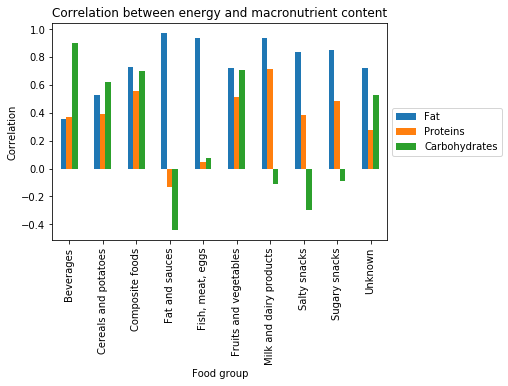

In [110]:
# Plot the previous results using a bar chart.
food_corr.plot.bar()
plt.xlabel('Food group')
plt.ylabel('Correlation')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title(food_corr.columns.name)

# It can be seen that the higher correlation between energy and macronutrient content are consistently for fat across fat/sauces, fish/meat/egss, milk/dairy, snacks of all sorts, fruits/vegetables, and unknown.
# On the other hand, carbohydrates also have a high correlation across beverages, composite foods, fruits/vegetables, and cereals/potatoes.
# Finally, proteins show a large correlation for milk/dairy, composite foods, and fish/meat/eggs.

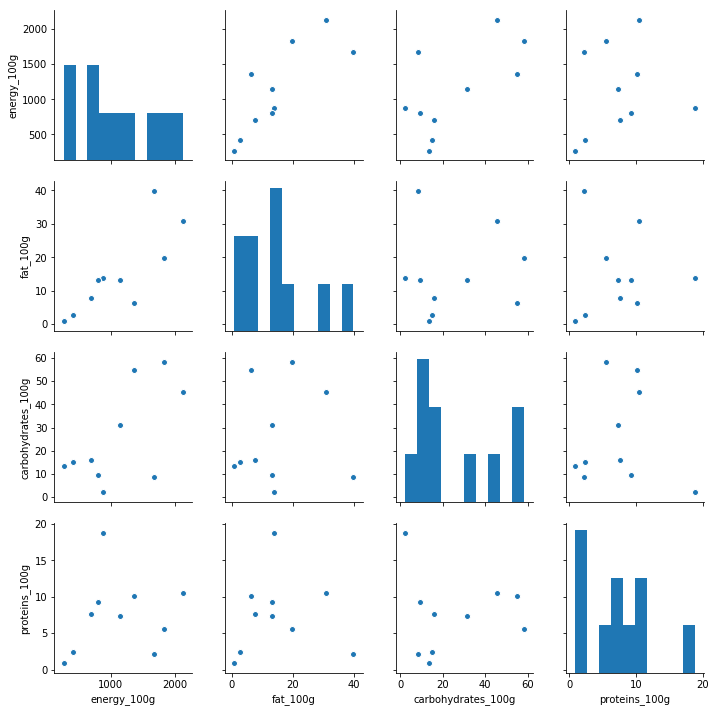

In [111]:
# We can also plot the graphs all in one to illustrate the relation between the mean energy content and the macronutrient content. 
sns.pairplot(food_sns)

In [19]:
# Exercise 2) You will filter and group your data based on the ingredients_text column. Your goal is to find the five most common ingredients.
# To do the exercise, we will first define a function that performs some cleaning on the textual data. We also need to use lists of English words and stopwords from the nltk package, so we will be calling them now as well.

stop=nl.stopwords.words('english')
english=nl.words.words()

def word_clean(s):
    s=s.str.lower() #transforms to lowercase
    s=s.str.replace('[(_:.%)\d\]\[\/]', ' ') #eliminates digits and punctuation except commas - this is to be able to separate the ingredients by concepts (eg 'orange juice') rather than words ('orange' + 'juice'). It is true that not all the entries have been thoroughly separated by commas, but we will assume that not much information is lost in this way.
    s=s.str.replace('(\s+(and)\s+)|&', ',') #replaces 'and' or '&' by a comma - rationale behind is the same as the previous one
    s=s.str.split(',', expand=True) #splits on commas and expand to create a dataframe
    s=pd.DataFrame(s.stack()).reset_index(drop=True)[0] #stack the dataframe (result: 2-level row multiindex), and further unstacks it by dropping the indeces and selecting only one column. The resulting object is a series.
    s=s.str.replace(r'\b({})\b'.format('|'.join(stop)), '') #remove English stopwords
    s=s.str.strip() #remove leading and trailing characters
    s=s[s!=""] #remove empty cells
    #s=s.str.replace(r'\b({})\b'.format('|'.join(english)), '') #remove words in languages other than English. This could actually go here if it were not for the fact that it takes more than 2 minutes to run. Therefore, the approach described further down will be the one taken.
    s=s.value_counts()[0:50].reset_index() #get the first 50 most frequent values: even if they are in a language other than English, it is highly likely that the 5 most common ingredients in English will be found among these 50. We will also reset the index to be able to easily access the ingredients strings.
    return s

In [20]:
# To avoid duplicates because of the countries reorg for the prior exercise, we will apply the cleaning function to the latest version of the food dataframe.
ingredients=word_clean(food['ingredients_text'])

In [21]:
eng_index=ingredients['index'].str.split(expand=True) #split all the ingredients substrings
eng_index=eng_index.isin(english) #check if the substrings exist in the English dictionary
eng_index['result']=eng_index.sum(axis=1).replace({0:False, 1:True, 2:True, 3:True, 4:True}) #assume ingredient is in foreign language if all the findings are False - True otherwise (not obvious though, as the word 'de' is recognised as an English word)

ingredients=ingredients[pd.concat([ingredients, eng_index['result']], axis=1)['result']==True].reset_index(drop=True) #map back the ingredients recognized as being in English.
ingredients.columns=['ingredient', 'number of occurences']
ingredients=ingredients[0:6]
ingredients # The most common ingredients are salt, sugar, water, citric acid, and folic acid. 'Sucre' appears as well because it is a French word but it cn also be found in English dictionaries (it is Ecuador's currency)

,ingredient,number of occurences
0,salt,89475
1,sugar,55811
2,water,50624
3,sucre,26553
4,citric acid,21671
5,folic acid,20889


In [22]:
# You will investigate more closely the created_datetime and last_modified_datetime.
# We will base our analysis on the latest cleaned version of the food database.
food_time=food.loc[:,['created_datetime', 'last_modified_datetime']] #select only the columns we are interested in
food_time=food_time.astype('datetime64[ns]', inplace=True) #convert both column values to datetime

#First, you will analyze the mean time difference between these two values. 
mean_difference=(food_time['last_modified_datetime']-food_time['created_datetime']).mean() 
mean_difference # Approximately 140 days and 20h is the mean time between entry creation and last modification

Timedelta('140 days 19:59:56.016477')

In [23]:
#And second, you will analyze the mean number of created items per month over the timeline of the data. 
#test=food_time.groupby(food_time['created_datetime'].dt.month).count()[['created_datetime']].rename(columns={'created_datetime':'Number of occurences'})

food_month=food_time.groupby([food_time['created_datetime'].dt.month, food_time['created_datetime'].dt.year]).count()[['created_datetime']].rename(columns={'created_datetime':'Number of occurences'}).unstack(level=0) #counts the number of occurences per year per month and puts them into a dataframe
food_month=food_month[1:7] # a bit of cleaning: delete the 1970 year
food_month.columns=food_month.columns.droplevel() # drop the outer column multilevel index by reassigning the names
food_month.columns=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] # change the index for the actual name of the month
food_month.columns.name='Month' # change the name of the columns
food_month.index=[2012, 2013, 2014, 2015, 2016, 2017] #same operations for the index
food_month.index.name='Year'
print(food_month)

food_month_mean=food_month.mean() # calculate the mean number of created items per month
food_month_mean.index.name=None # removes the name of the index
food_month_mean

Month  January  February     March   April     May    June    July  August  \
Year                                                                         
2012       1.0      10.0     147.0   168.0   398.0   847.0   488.0   156.0   
2013     379.0     538.0     484.0  1130.0   608.0   566.0   629.0   869.0   
2014     537.0     651.0     701.0  1047.0   836.0   739.0   652.0   866.0   
2015    1475.0    2734.0    2659.0  2451.0  1779.0  1734.0  1877.0  1725.0   
2016    2006.0    1411.0    1814.0  2999.0  2928.0  1250.0  1056.0  1015.0   
2017    1358.0    2282.0  129910.0  2030.0  1998.0  2009.0  1770.0  2180.0   

Month  September  October  November  December  
Year                                           
2012       421.0    516.0     587.0     304.0  
2013       941.0    857.0     546.0     658.0  
2014       716.0    771.0    1370.0    1085.0  
2015      1388.0   1343.0    1547.0    2097.0  
2016      2470.0   2194.0    1383.0    1556.0  
2017      1043.0      NaN       NaN    

January        959.333333
February      1271.000000
March        22619.166667
April         1637.500000
May           1424.500000
June          1190.833333
July          1078.666667
August        1135.166667
September     1163.166667
October       1136.200000
November      1086.600000
December      1140.000000
dtype: float64

Text(0,0.5,'Number of items')

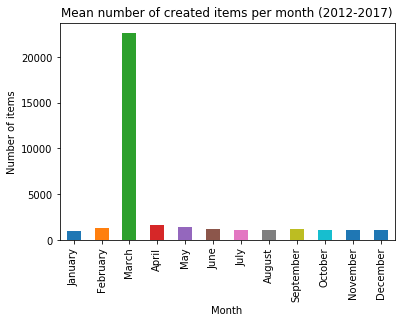

In [24]:
# For the second question, you will also choose an appropriate method to visualize your findings.
food_month_mean.plot.bar()
plt.title('Mean number of created items per month (2012-2017)')
plt.xlabel('Month')
plt.ylabel('Number of items')

In [30]:
# You will build a database to hold your data. It is up to you to define appropriate tables and well as primary keys for connecting them. (The focus is definitely more on just using the basic methods/tools introduced in the course and not on building a complex database.) In particular, you can follow the following list of steps:
# restrict your data to 1000 entries and 5 columns of your choice
food_db = sql.connect("/Users/David/Desktop/EPFL Applied ML/food.db") #create a connection to an empty sqlite3 database. Change the path as needed.
#create one or multiple tables, at least one of the tables should have a PRIMARY KEY
query_time='''
CREATE TABLE time 
(code PRIMARY KEY, 
created_t INTEGER, 
created_datetime TEXT, 
last_modified_t INTEGER, 
last_modified_datetime TEXT);
'''
query_nutritional='''
CREATE TABLE nutritional 
(code PRIMARY KEY, 
`nutrition-score-fr_100g` REAL, 
`nutrition-score-uk_100g` REAL, 
energy_100g REAL, 
fat_100g REAL,
carbohydrates_100g REAL,
proteins_100g REAL,
salt_100g REAL);
'''
query_other='''CREATE TABLE other 
(code PRIMARY KEY, 
product_name TEXT, 
packaging TEXT, 
countries_en TEXT, 
pnns_groups_1 TEXT,
pnns_groups_2 TEXT);
'''

In [31]:
#fill the database with your data
food_to_db=food[0:1000]
#run at least one query to demonstrate that it works correctly

In [32]:
cursor = food_db.cursor()
cursor.execute(query_time)
cursor.execute(query_nutritional)
cursor.execute(query_other)
food_db.commit()

#alternative way of calling the query:
#pd.read_sql_query(query_time, food_db)
#pd.read_sql_query(query_nutritional, food_db)
#pd.read_sql_query(query_other, food_db)

In [33]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall()) # indeed, the tables have been correctly created in the database

[('time',), ('nutritional',), ('other',)]


In [34]:
food_to_db[['code', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime']].to_sql(name='time', con=food_db, if_exists='append', index=False)
food_to_db[['code', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g']].to_sql(name='nutritional', con=food_db, if_exists='append', index=False)
food_to_db[['code', 'product_name', 'packaging', 'countries_en', 'pnns_groups_1', 'pnns_groups_2']].to_sql(name='other', con=food_db, if_exists='append', index=False)
food_db.commit()

In [35]:
cursor.execute("SELECT countries_en, product_name FROM other;")
print(cursor.fetchall()) # indeed, the table 'other' has been populated as requested, as it can be seen by the extraction of two specific columns

[('United States', 'Peanuts'), ('United States', 'Granola Cranberry And Acai'), ('United States', 'Peanuts, Mixed Nuts'), ('United States', 'Cranberries'), ('United States', 'Turkish Apricots'), ('United States', 'Banana Chips Sweetened'), ('United States', 'Granola Honey Almonds'), ('United States', 'Chili Mango'), ('United States', 'Milk Chocolate Pretzels'), ('United States', 'Peanuts'), ('United States', 'Fresh Organic Carrots'), ('Canada', 'Salade Cesar'), ('Canada', 'Danoises à la cannelle roulées'), ('Canada', 'Chaussons tressés aux pommes'), ('Canada', 'Pain Burger Artisan'), ('France', 'Root Beer'), ('France', 'Biscuits sablés fourrage au cacao'), ('Canada', 'Quiche Lorraine'), ('Canada', 'Pâté au poulet'), ('France', 'Gotta-have grape, seriously strawberry flavor'), ('France', 'Thé de Noël aromatisé orange-cannelle'), ('United Kingdom', 'เล็บมือนาง (ตีนไก่ )'), ('United States', 'Butter Croissants'), ('United States', 'Wild Blueberry Muffins'), ('United States', 'Bolillos'), 

In [36]:
# You will try to find correlations between the different data fields. 
# Your goal is to identify the variables which most affect the nutritional score and provide some insight into which factors cause both a low or a high nutritional score.

nutrition_corr=food.corr().sort_values(by = ['nutrition-score-fr_100g','nutrition-score-uk_100g'], ascending=False)[['nutrition-score-fr_100g', 'nutrition-score-uk_100g']] # find correlations between numerical variables and nutrition scores (both fr and uk variants, sorted by fr first)
nut_score=['nutrition-score-fr_100g', 'nutrition-score-uk_100g'] # filtering list to be applied later
nutrition_corr.loc[~nutrition_corr.index.isin(nut_score+['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']), nut_score] # final dataframe, with selected rows and columns. Ingredients from palm oil and related have been eliminated from the final view as they were integers (even if declared as floats), so a linear correlation didn't make much sense.  

# First thing to know is that the nutrition scores, at least on its UK definition found on https://www.food.gov.uk/northern-ireland/nutritionni/niyoungpeople/nutlab/nutprofmod, implies that the highest the score, the less healthy the food is.
# According to the results, the factors (per 100g) that have a higher positive influence on the score are saturated fats, energy, fats, and sugar. As expected by day-to-day experience. On the other hand, de amount of fiber has a slight negative influence - therefore foods with a large amount of fiber are linked to lower nutrition scores, and therefore are deemed healthier.

,nutrition-score-fr_100g,nutrition-score-uk_100g
saturated-fat_100g,0.627668,0.655966
energy_100g,0.619894,0.662096
fat_100g,0.554215,0.598191
sugars_100g,0.470383,0.454654
carbohydrates_100g,0.260211,0.262980
proteins_100g,0.107182,0.142480
sodium_100g,0.041928,0.044497
salt_100g,0.041928,0.044497
cholesterol_100g,0.035294,0.035368
trans-fat_100g,0.021265,0.021399


In [37]:
# This correlation only takes into account the influence of the variables on the nutrition outcome, but it does not tell us about possible relations between the variables themselves and their influence on the nutrition score. 
# To get a glimpse into other relations, we could use the statsmodel package to do a multifit (for example, of the uk nutrition score):

food_multi=food[['nutrition-score-uk_100g', 'saturated-fat_100g', 'energy_100g', 'fat_100g', 'sugars_100g', 'carbohydrates_100g', 'proteins_100g', 'sodium_100g', 'salt_100g', 'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'potassium_100g', 'iron_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'fiber_100g']]
food_multi=food_multi.dropna(how='any', axis=[0,1])

y = food_multi['nutrition-score-uk_100g']
x = food_multi[['saturated-fat_100g', 'energy_100g', 'fat_100g', 'sugars_100g', 'carbohydrates_100g', 'proteins_100g', 'sodium_100g', 'salt_100g', 'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'potassium_100g', 'iron_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'fiber_100g']]
x = sm.add_constant(x)

multifit = sm.OLS(y, x).fit()
multifit.summary()

# The results suggest that, apart from the predictors identified previously, carbohydrates, colesterol, calcium and vitamin A also play an important role on the overall outcome of the nutrition score. Furthermore, even if some of the predictors fail the t-tests, the overall regression is significant itself because it has a large F-test. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     nutrition-score-uk_100g   R-squared:                       0.752
Model:                                 OLS   Adj. R-squared:                  0.752
Method:                      Least Squares   F-statistic:                     3690.
Date:                     Sun, 22 Apr 2018   Prob (F-statistic):               0.00
Time:                             16:36:34   Log-Likelihood:                -54280.
No. Observations:                    19488   AIC:                         1.086e+05
Df Residuals:                        19471   BIC:                         1.087e+05
Df Model:                               16                                         
Covariance Type:                 nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.9071      0.053    -36.107      0.000      -2.011      -1.804
saturated-fat_100g     0.6070      0.010     63.349      0.000       0.588       0.626
energy_100g            0.0038      0.000     17.559      0.000       0.003       0.004
fat_100g               0.0504      0.008      6.115      0.000       0.034       0.067
sugars_100g            0.1732      0.002     72.205      0.000       0.168       0.178
carbohydrates_100g     0.0236      0.004      6.011      0.000       0.016       0.031
proteins_100g         -0.0103      0.006     -1.862      0.063      -0.021       0.001
sodium_100g          266.4663    394.119      0.676      0.499    -506.040    1038.973
salt_100g           -104.8564    155.165     -0.676      0.499    -408.993     199.280
cholesterol_100g      24.7888      1.673     14.817      0.000      21.510      28.068
trans-fat_100g        -0.0828      0.056     -1.477      0.140      -0.193       0.027
calcium_100g           1.6460      0.184      8.956      0.000       1.286       2.006
potassium_100g        -0.0129      0.007     -1.986      0.047      -0.026      -0.000
iron_100g             -0.5112      0.340     -1.505      0.132      -1.177       0.155
vitamin-a_100g       396.8172     46.462      8.541      0.000     305.748     487.886
vitamin-c_100g         0.8648      0.511      1.693      0.090      -0.136       1.866
fiber_100g            -0.4439      0.008    -56.082      0.000      -0.459      -0.428
==============================================================================
Omnibus:                     2603.540   Durbin-Watson:                   1.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19884.947
Skew:                          -0.409   Prob(JB):                         0.00
Kurtosis:                       7.881   Cond. No.                     1.98e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

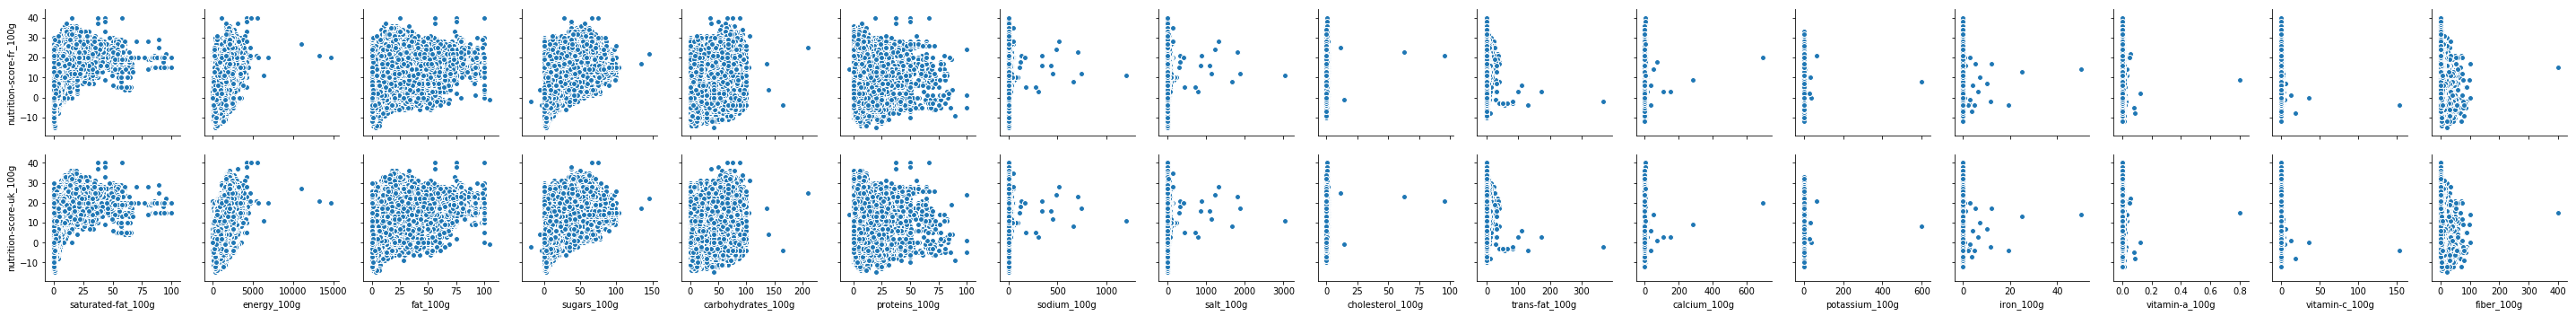

In [33]:
# Pair-plots of the variables studied previously.
sns.pairplot(food, x_vars = nutrition_corr.index[~nutrition_corr.index.isin(nut_score+['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'])], y_vars = nut_score)